In [2]:
import pandas as pd
import numpy as np
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from enum import StrEnum

In [6]:
data = pd.read_csv('final_products_05_05_2025_09_59.csv')
data = data[(data['Вес (кг)'] <= 0.1) & (data['Вес (кг)']>= 0.075)]
data = data[data['Тип'] == 'Шоколадная плитка']
brands = ['Россия Щедрая Душа', 'Ritter Sport', 'Alpen Gold', 'Milka', 'Алёнка', 'Schogetten', 'Bucheron',
 'Бабаевский', 'Вдохновение', 'Merci', 'Степ', 'Kinder']
data = data[np.isin(data['Бренд'], brands)]
data = data.reset_index()[['Название', 'Текущая цена', 'Бренд', 'Рейтинг', 'Ккал', 'Упаковка', 'Тип шоколада', 'Какао (%)', \
        'Состав']].rename(columns={'Название': 'name', 'Текущая цена': 'price', 'Бренд': 'brand', 'Рейтинг': 'rating', 'Ккал': 'kcal', \
        'Упаковка': 'package', 'Тип шоколада': 'type', 'Какао (%)': 'cacao', 'Состав': 'Состав'})
data.head(5)

,name,price,brand,rating,kcal,package,type,cacao,Состав
0,Шоколад белый Миндаль и кокос Alpen Gold 80г,74.99,Alpen Gold,4.8,545.0,флоупак,Белый,22.0,"Сахар, масло какао, сыворотка сухая молочная, ..."
1,Шоколад белый пористый Россия щедрая душа 75г,74.99,Россия Щедрая Душа,4.8,545.0,флоупак,Белый,25.0,"Сахар, масло какао, молоко сухое цельное, сыво..."
2,Шоколад Классический Чизкейк Alpen Gold 85/90г,74.99,Alpen Gold,4.8,533.0,флоупак,Молочный,25.0,"Сахар, жир растительный (масло пальмовое), печ..."
3,Шоколад молочный Россия щедрая душа 82г,79.99,Россия Щедрая Душа,4.8,539.0,флоупак,Молочный,27.0,"Сахар, масло какао, молоко сухое цельное, кака..."
4,Шоколад белый Gold Selection Дуэт в клубнике Р...,88.99,Россия Щедрая Душа,4.8,543.0,флоупак,Белый,20.0,"Сахар, масло какао, молоко сухое цельное, сыво..."


### Бренд:

In [9]:
data['brand'].value_counts(dropna=False)

brand
Россия Щедрая Душа    23
Ritter Sport          22
Alpen Gold            20
Milka                 13
Алёнка                13
Schogetten            12
Bucheron              12
Бабаевский             8
Вдохновение            5
Merci                  4
Степ                   3
Kinder                 3
Name: count, dtype: int64

### Тип шоколада:

In [12]:
data['type'].value_counts(dropna=False)

type
Молочный    87
Темный      24
Белый       12
Горький     12
NaN          3
Name: count, dtype: int64

In [14]:
data[data['type'].isna()]

,name,price,brand,rating,kcal,package,type,cacao,Состав
9,Шоколад молочный и белый пористый Россия щедра...,79.99,Россия Щедрая Душа,4.8,542.0,флоупак,NaN,27.0,"Сахар, масло какао, молоко сухое цельное, сыво..."
16,Шоколад Трилогия Schogetten 100г,149.99,Schogetten,4.8,557.0,картонная упаковка,NaN,30.0,"Масло какао, сахар, паста из ореха фундук, сух..."
35,Шоколад Мороженое Schogetten 100г,149.99,Schogetten,4.8,546.0,картонная упаковка,NaN,30.0,"Сахар, какао-масло, какао-паста, сухое обезжир..."


In [16]:
data = data[~data['type'].isna()].reset_index().drop(columns='index')

### Калорийность:

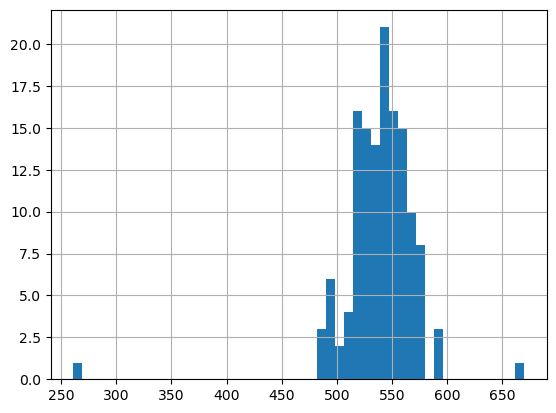

In [65]:
data['kcal'].hist(bins=50);

### Добавки:

In [22]:
def filling(name):    
    class Type(StrEnum):
        NUTS = "NUTS"
        BERRIES = "BERRIES"
        SNACKS = "SNACKS"
        DESSERT = "DESSERT"
        EXOTIC = "EXOTIC"
        NO_FILLING = "NO_FILLING"
    
    class AIOutput(BaseModel):
        Types: list[Type]
    
    text_prompt = """
        У тебя есть название шоколадки. Определи все начинки, содержащиеся в шоколаде, по категориям, представленным ниже.
        То есть отнести все элементы из начинки шоколадки по соответствующим категориям, после чего верни список из всех категорий,
        элементы которых встречаются в начинке шоколадки.
        
        1. NUTS, если начинка содержит орехи, например:
        Миндаль, Фундук, Лесной орех, Кешью , Арахис, Фисташки, Грецкий орех
        При этом, если начинка является десертной со вкусом ореха, тебе не стоит относить начинку к данной категории.
        
        2. BERRIES, если начинка содержит ягоды или сухофрукты, например: 
        Клубника, Малина, Вишня, Черника, Клюква, Изюм  
        При этом, если ягода используется в йогуртовой начинке, тебе не стоит относить начинку к данной категории
        
        3. SNACKS, если начинка содержит печенье, вафли или другие хрустящие элементы, например:  
        Печенье, Вафли, Воздушный рис, Хлопья
        
        4. DESSERT, если начинка содержит йогуртовую или десертную начинку, например: 
        Йогуртные начинки с разными вкусами, начинки помадка, тирамису, крем-брюле и тд 
        
        5. EXOTIC, если начинка является достаточно экзотической и нечасто встречается в шоколаде, например:
        Лаванда, Роза, Мёд, Матча, Тыквенные семечки, Кунжут и т.д.
        
        6. NO_FILLING, если шоколад не содержит никакой начинки из вышеперечисленных категорий
    
        Название шоколадки:
                {name}
    
        <FORMAT_INSTRUCTIONS>:
                {format_instructions}
    """
    
    
    model = ChatOpenAI(model="gpt-4.1", api_key=OPENAI_API_KEY)
    parser = PydanticOutputParser(pydantic_object=AIOutput)
    
    prompt = PromptTemplate(
        template=text_prompt,
        input_variables=["name"],
        partial_variables={
            "format_instructions": parser.get_format_instructions(),
        }
    )
    
    chain = prompt | model | parser
    
    result = chain.invoke({
            "name": name
            })
    
    ans = []
    for t in result.Types:
        ans.append(str(t))

    return ans

In [24]:
# data['filling'] = data['name'].map(lambda x: filling(x))
# filling = {data.loc[ind]['name']: data.loc[ind]['filling'] for ind in data.index}
# with open('fillings.json', "w", encoding="utf-8") as json_file:
#     json.dump(filling, json_file, indent=4, ensure_ascii=False)

In [30]:
with open('fillings.json', "r", encoding="utf-8") as json_file:
     filling = json.load(json_file)

In [32]:
data['filling'] = data['name'].map(filling)
data['filling_NUTS'] = data['filling'].map(lambda x: 1 if 'NUTS' in x else 0)
data['filling_BERRIES'] = data['filling'].map(lambda x: 1 if 'BERRIES' in x else 0)
data['filling_SNACKS'] = data['filling'].map(lambda x: 1 if 'SNACKS' in x else 0)
data['filling_DESSERT'] = data['filling'].map(lambda x: 1 if 'DESSERT' in x else 0)
data['filling_EXOTIC'] = data['filling'].map(lambda x: 1 if 'EXOTIC' in x else 0)

### Содержание какао:

In [35]:
data['cacao'].isna().sum()

16

In [37]:
data[data['cacao'].isna()]

,name,price,brand,rating,kcal,package,type,cacao,Состав,filling,filling2,filling_NUTS,filling_BERRIES,filling_SNACKS,filling_DESSERT,filling_EXOTIC
23,Шоколад White Chocolate белый Schogetten 100г,134.99,Schogetten,4.9,555.0,картонная упаковка,Белый,NaN,"Сахар, какао-масло, сухое обезжиренное молоко,...",[NO_FILLING],[NO_FILLING],0,0,0,0,0
33,Шоколад Aerated белый пористый Alpen Gold 75г,89.99,Alpen Gold,4.8,527.0,флоупак,Белый,NaN,"Сахар, масло какао, сыворотка сухая молочная, ...",[NO_FILLING],[NO_FILLING],0,0,0,0,0
39,Шоколад белый Schogetten Chai Latte 100г,149.99,Schogetten,4.2,561.0,картонная упаковка,Белый,NaN,"Сахар, пальмовый жир, сухое цельное молоко, ка...","[DESSERT, EXOTIC]","[DESSERT, EXOTIC]",0,0,0,1,1
55,Шоколад Клубничный йогурт Schogetten 100г,119.99,Schogetten,4.8,563.0,картонная упаковка,Молочный,NaN,"Сахар, пальмовый жир, какао-масло, сухое йогур...",[DESSERT],[DESSERT],0,0,0,1,0
58,Шоколад молочный Popcorn Schogetten 100г,149.99,Schogetten,4.7,554.0,картонная упаковка,Молочный,NaN,"Сахар, пальмовый жир, сухое цельное молоко, ка...",[SNACKS],[SNACKS],0,0,1,0,0
59,Шоколад молочный Соленая карамель Ritter Sport...,159.99,Ritter Sport,4.8,535.0,флоупак,Молочный,NaN,"Сахар, масло какао, какао тертое, соленая кара...",[DESSERT],[DESSERT],0,0,0,1,0
60,Шоколад белый с лимонной начинкой Ritter Sport...,169.99,Ritter Sport,4.7,589.0,флоупак,Белый,NaN,"Шоколад белый (сахар, масло какао, сухое цельн...",[EXOTIC],[EXOTIC],0,0,0,0,1
72,Шоколад молочный с ореховой нугой Schogetten 100г,149.99,Schogetten,4.7,547.0,картонная упаковка,Молочный,NaN,"Сахар, масло какао, паста из фундука (13%), су...",[DESSERT],[DESSERT],0,0,0,1,0
81,Шоколад белый Schogetten Blonde Almond 100г,149.99,Schogetten,NaN,553.0,картонная упаковка,Белый,NaN,"Сахар, какао-масло, сухое цельное молоко, минд...",[NUTS],[NUTS],1,0,0,0,0
85,Шоколад молочный с кусочками кренделя Ritter S...,169.99,Ritter Sport,NaN,518.0,флоупак,Молочный,NaN,"Шоколад молочный (сахар, масло какао, какао те...",[SNACKS],[SNACKS],0,0,1,0,0


In [43]:
def fillna_cacao(row):
    if row['type'] == 'Белый':
        return 0
    if row['type'] == 'Молочный' and row['brand'] == 'Schogetten':
        return 30
    if row['type'] == 'Молочный' and row['brand'] == 'Ritter Sport':
        return 33
    if row['type'] == 'Молочный' and row['brand'] == 'Алёнка':
        return 30
    if row['brand'] == 'Kinder':
        return 13
    if row['type'] == 'Темный' and row['brand'] == 'Schogetten':
        return 50

In [51]:
data['cacao'] = data.apply(lambda x: fillna_cacao(x) if pd.isna(x['cacao']) else x['cacao'], axis=1)

In [55]:
data['cacao'].isna().sum()

0

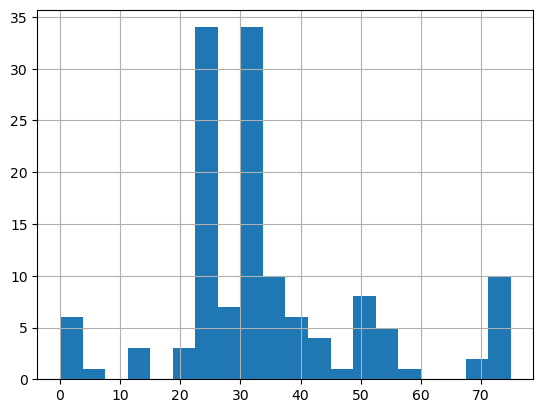

In [63]:
data['cacao'].hist(bins=20);

### Упаковка:

In [71]:
data['package'].value_counts(dropna=False)

package
флоупак               85
картонная упаковка    32
бумажная упаковка     18
Name: count, dtype: int64

In [73]:
data['package'].isna().sum()

0

### Рейтинг:

In [79]:
data['rating'].isna().sum()

8

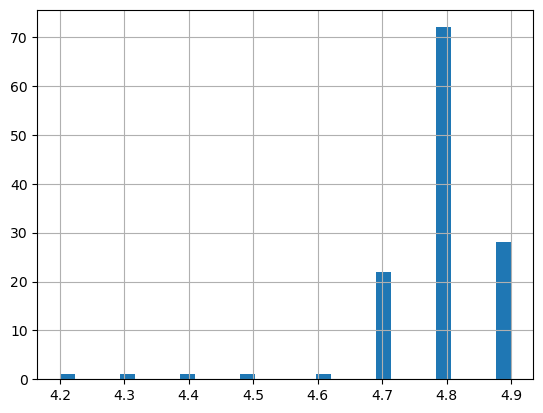

In [87]:
data['rating'].hist(bins=30);

In [93]:
data['rating'] = data['rating'].fillna(data['rating'].mode())

## Наличие эмульгаторов:

In [117]:
def emulsifier(text):
    for i in range(len(text) - 1):
        if text[i] == 'Е' and text[i + 1] in '1234567890':
            return 1
    return 0

In [119]:
data['emulsifiers'] = data['Состав'].map(lambda x: emulsifier(x))

In [123]:
data.columns

Index(['name', 'price', 'brand', 'rating', 'kcal', 'package', 'type', 'cacao',
       'Состав', 'filling', 'filling2', 'filling_NUTS', 'filling_BERRIES',
       'filling_SNACKS', 'filling_DESSERT', 'filling_EXOTIC', 'emulsifiers'],
      dtype='object')

In [129]:
data[['price', 'brand', 'rating', 'kcal', 'package', 'type', 'cacao', 'filling_NUTS', 'filling_BERRIES', \
       'filling_SNACKS', 'filling_DESSERT', 'filling_EXOTIC', 'emulsifiers']].to_csv('chocolate_data.csv', index=False)

### Цена.

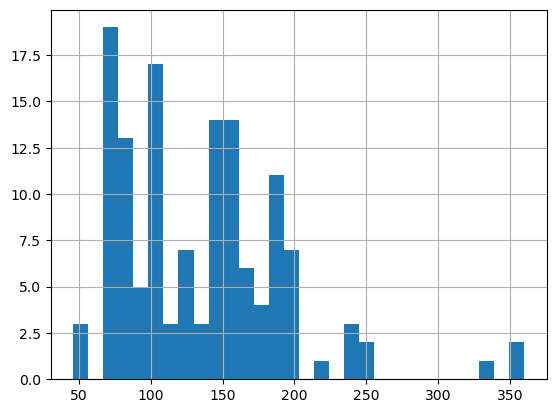

In [146]:
data['price'].hist(bins=30);